In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from pickle import load
from sklearn.metrics import mean_squared_error

########## Test dataset #########

In [7]:
# Load scaler/ index
X_scaler = load(open('X_scaler.pkl', 'rb'))
y_scaler = load(open('y_scaler.pkl', 'rb'))
train_predict_index = np.load("index_train.npy", allow_pickle=True)
test_predict_index = np.load("index_test.npy", allow_pickle=True)


In [8]:
# Load test dataset/ model
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)

/tmp/ipykernel_9172/2718365482.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predict_result['predicted_mean'] = predict_result.mean(axis=1)
/tmp/ipykernel_9172/2718365482.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_price['real_mean'] = real_price.mean(axis=1)


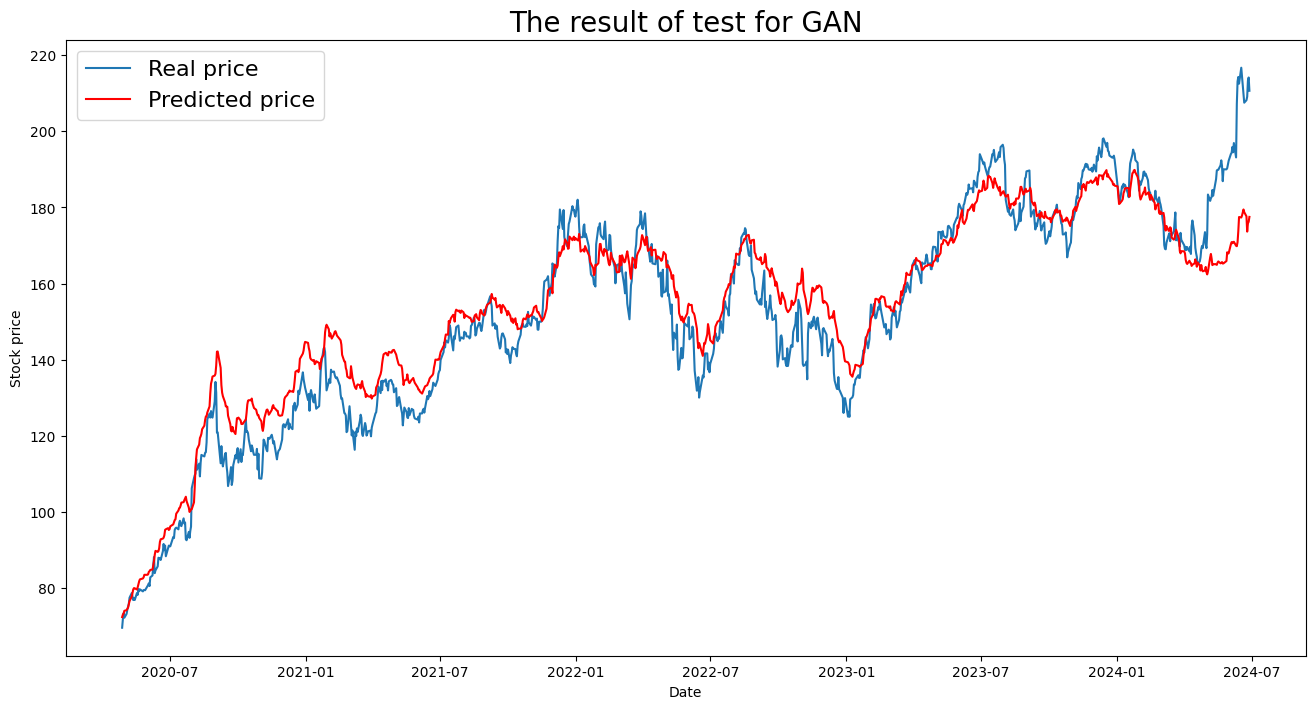

-- RMSE for GAN --  8.977886287420299


/tmp/ipykernel_9172/2718365482.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predict_result['predicted_mean'] = predict_result.mean(axis=1)
/tmp/ipykernel_9172/2718365482.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_price['real_mean'] = real_price.mean(axis=1)


<Figure size 640x480 with 0 Axes>

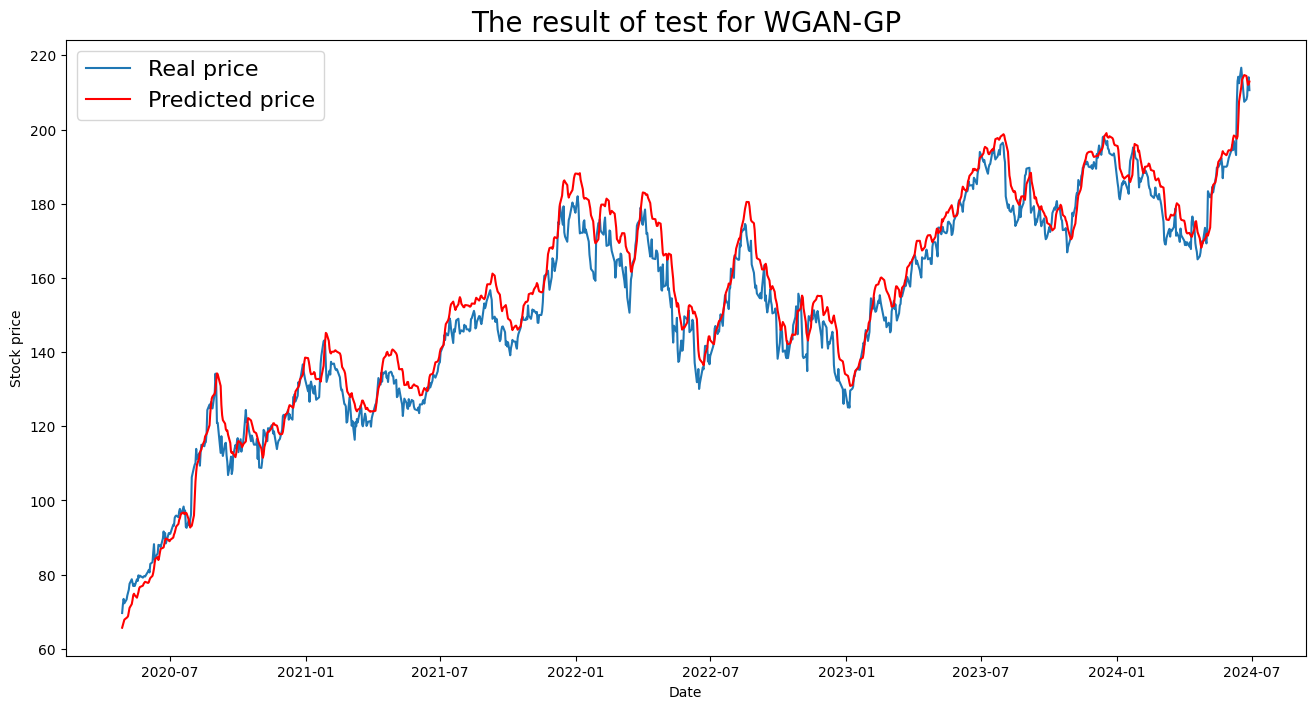

-- RMSE for WGAN-GP --  5.922690127907124


<Figure size 640x480 with 0 Axes>

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from pickle import load
from sklearn.metrics import mean_squared_error

# Load scaler/ index
X_scaler = load(open('X_scaler.pkl', 'rb'))
y_scaler = load(open('y_scaler.pkl', 'rb'))
train_predict_index = np.load("index_train.npy", allow_pickle=True)
test_predict_index = np.load("index_test.npy", allow_pickle=True)

# Load test dataset
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)

def get_test_plot(model, X_test, y_test, model_name):
    # Set output steps
    output_dim = y_test.shape[1]

    # Get predicted data
    y_predicted = model(X_test)
    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(y_predicted)

    ## Predicted price
    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    ## Real price
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"], index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"The result of test for {model_name}", fontsize=20)
    plt.show()
    plt.savefig(f'test_plot_{model_name}.png')
    
    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print(f'-- RMSE for {model_name} -- ', RMSE)

    return predict_result, RMSE

# Load and evaluate the first model
G_model_1 = tf.keras.models.load_model('gen_model_3_1_164.h5')
test_predicted_1, test_RMSE_1 = get_test_plot(G_model_1, X_test, y_test, 'GAN')

# Save predictions to CSV
test_predicted_1.to_csv("test_predicted_1.csv")

# Load and evaluate the second model
G_model_2 = tf.keras.models.load_model('gen_GRU_model_89.h5')
test_predicted_2, test_RMSE_2 = get_test_plot(G_model_2, X_test, y_test, 'WGAN-GP')

# Save predictions to CSV
test_predicted_2.to_csv("test_predicted_2.csv")


In [10]:
RMSE = {
    '': ['RMSE（Train）', 'RMSE（test exclude 2020）', 'RMSE（test include 2020）'],
    'LSTM': [3.82, 2.67, 3.46],
    'GRU': [0.75, 3.10, 3.80],
    'GAN': [0.70, 1.62, 3.26],
    'WGAN': [0.59, 1.89, 2.95]
}


df = pd.DataFrame(RMSE)


df.set_index('', inplace=True)


print(df)


df.to_csv('rmse_results.csv')



                         LSTM   GRU   GAN  WGAN
                                               
RMSE（Train）              3.82  0.75  0.70  0.59
RMSE（test exclude 2020）  2.67  3.10  1.62  1.89
RMSE（test include 2020）  3.46  3.80  3.26  2.95
